In [44]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

### Definition of reference potential

In [45]:
class potential:
    def __init__(self, x, y, q):
        self.point_x = x
        self.point_y = y
        self.point_charge = q

### Object for many potentials

In [46]:
class MUL_potential:
    def __init__(self, x_arr: np.array([]), y_arr: np.array([]), charge_arr: np.array([])):
        if(len(x_arr) != len(y_arr) or len(x_arr) != len(charge_arr)):
            print("Can't initialize using arrays of different length.")

        else:
            self.potentials = np.array([])

            for i in range(0, len(x_arr)):
                self.potentials = np.append(self.potentials, potential(x_arr[i], y_arr[i], charge_arr[i]))

### Definition of particle

In [47]:
class particle:
    def __init__(self, alpha, d, q):
        self.particle_angle = alpha
        self.particle_len = d
        self.particle_charge = q

        #first electron
        self.e1_x = self.particle_len * math.cos((math.pi / 180) * self.particle_angle)
        self.e1_y = self.particle_len * math.sin((math.pi / 180) * self.particle_angle)

        #2nd electron
        if(self.particle_angle + 120 < 360):
            self.e2_x = self.particle_len * math.cos((math.pi / 180) * (self.particle_angle + 120))
            self.e2_y = self.particle_len * math.sin((math.pi / 180) * (self.particle_angle + 120))
        else:
            self.e2_x = self.particle_len * math.cos((math.pi / 180) * (self.particle_angle - 240))
            self.e2_y = self.particle_len * math.sin((math.pi / 180) * (self.particle_angle - 240))

        #3rd electron
        if(self.particle_angle - 120 > 0):
            self.e3_x = self.particle_len * math.cos((math.pi / 180) * (self.particle_angle - 120))
            self.e3_y = self.particle_len * math.sin((math.pi / 180) * (self.particle_angle - 120))
        else:
            self.e3_x = self.particle_len * math.cos((math.pi / 180) * (self.particle_angle + 240))
            self.e3_y = self.particle_len * math.sin((math.pi / 180) * (self.particle_angle + 240))

### Functions for potential and energy for single reference potential

In [48]:
def getPotential(p: particle, r: potential):
    v1 = 1.0 / (math.sqrt(math.pow(r.point_x - p.e1_x, 2) + math.pow(r.point_y - p.e1_y, 2)))
    v2 = 1.0 / (math.sqrt(math.pow(r.point_x - p.e2_x, 2) + math.pow(r.point_y - p.e2_y, 2)))
    v3 = 1.0 / (math.sqrt(math.pow(r.point_x - p.e3_x, 2) + math.pow(r.point_y - p.e3_y, 2)))

    return v1 + v2 + v3

def getEnergy(p: particle, r: potential):
    k_c = 8.9875517923 * 1.60217662 / 10

    return k_c * r.point_charge * p.particle_charge * getPotential(p, r)

### Energy for multiple potentials

In [49]:
def getEnergy_MUL(p: particle, pot: MUL_potential):
    k_c = 8.9875517923 * 1.60217662 / 10
    acc = 0

    for i in range(0, len(pot.potentials)):
        r = pot.potentials[i]
        acc += k_c * r.point_charge * p.particle_charge * getPotential(p, r)

    return acc

### Function to rotate particle with single potential

In [50]:
def tryRotating(p: particle, r: potential, alpha, T):
    if(p.particle_angle + alpha >= 120):
        alpha = alpha - 120
    elif(p.particle_angle + alpha < 0):
        alpha = alpha + 120

    #create particle at new angle
    p1 = particle(p.particle_angle + alpha, p.particle_len, p.particle_charge)

    #get old and new energy
    E_old = getEnergy(p, r)
    E_new = getEnergy(p1, r)

    #boltzmann constant in [eV/K]
    k_b = 8.617333262145 * math.pow(10, -5)

    #if new energy is lower than old, return new angle
    if(E_new - E_old < 0):
        return p1

    else:
        w = math.exp(-(E_new - E_old) / (T * k_b))
        rand = random.random()

        if(rand <= w):
            return p1
        else:
            return p

### Rotating for multiple potentials

In [51]:
def tryRotating_MUL(p: particle, pot: MUL_potential, alpha, T):
    if(p.particle_angle + alpha >= 120):
        alpha = alpha - 120
    elif(p.particle_angle + alpha < 0):
        alpha = alpha + 120

    #create particle at new angle
    p1 = particle(p.particle_angle + alpha, p.particle_len, p.particle_charge)

    #get old and new energy
    E_old = getEnergy_MUL(p, pot)
    E_new = getEnergy_MUL(p1, pot)

    #boltzmann constant in [eV/K]
    k_b = 8.617333262145 * math.pow(10, -5)

    #if new energy is lower than old, return new angle
    if(E_new - E_old < 0):
        return p1

    else:
        w = math.exp(-(E_new - E_old) / (T * k_b))
        rand = random.random()

        if(rand <= w):
            return p1
        else:
            return p

### Physical constants and variables for simulation

In [52]:
#physical stuff - charge is in [e], distances are in [nm]
phi = 0.5
T = 5 * pow(10, -3)

#multipliers for particle
d1 = 0.2
Q2 = 0.5

#multipliers for potential
d2 = 30
#pot_x = d2
#pot_y = 0
pot_x = np.array([d2, d2 * math.cos((math.pi / 180) * 72), d2 * math.cos((math.pi / 180) * 144), d2 * math.cos((math.pi / 180) * 216), d2 * math.cos((math.pi / 180) * 288)])
pot_y = np.array([0, d2 * math.sin((math.pi / 180) * 72), d2 * math.sin((math.pi / 180) * 144), d2 * math.sin((math.pi / 180) * 216), d2 * math.sin((math.pi / 180) * 288)])
#pot_x = np.array([d2, 0, -d2, 0])
#pot_y = np.array([0, d2, 0, -d2])
Q1 = -300
#pot_q = Q1
pot_q = np.array([Q1, Q1, Q1, Q1, Q1])
AngleInt = int(120 / phi)

#MC steps
mc = 2000000

### Creation of particle and reference potentials

In [53]:
p = particle(0, d1, Q2)

#multiple potentials
ref = MUL_potential(pot_x, pot_y, pot_q)

#single potential
#ref = potential(pot_x, pot_y, pot_q)

### Array to keep track of particle position and energy for quick plotting

In [54]:
#count based on angle
avg = np.array([])
for i in range(0, int(120 / phi)):
    avg = np.append(avg, 0.0)

#energy based on MC step
en_mc = np.array([])

#angle based on MC step
ang_mc = np.array([])

### Opening files to append

In [55]:
#checking which run we're on
for i in range(0, 1000):
    if(exists('Results\\' + str(i) + '_Angle_Count.csv') == False):
        run = i
        break

#positions of potentials
R = ""
if(type(ref) == potential):
    R = "(" + str(pot_x) + ", " + str(pot_y) + ")"

else:
    for i in range(0, len(pot_x)):
        R += "(" + str(pot_x[i]) + ", " + str(pot_y[i]) + ")"

#save parameters
params = open('Results\parameters.txt', 'a+')
params.write("\n===========\n")
params.write("Run " + str(run) +  "\n===========\n")
params.write("Q1 = " + str(Q1) + "\nQ2 = " + str(Q2) + "\nd = " + str(d1) + "\nR = " + R + " \nphi = " + str(phi) + "\nT = " + str(T))
params.close()

### Main loop for rotating particle

In [56]:
for i in range(0, mc):

    #generate random number to check which way we're gonna rotate
    rng = random.random()

    #single potential
    if(type(ref) == potential):    
        #rotate counter-clockwise
        if(rng > 0.5):
            p = tryRotating(p, ref, phi, T)

        #rotate clockwise
        else:
            p = tryRotating(p, ref, -phi, T)

        #get energy so we can write it to file
        if(i >= 10000 and i < 100000):
            en_mc = np.append(en_mc, getEnergy(p, ref))
            ang_mc = np.append(ang_mc, p.particle_angle)
    
    #multiple potentials
    else:
        #rotate counter-clockwise
        if(rng > 0.5):
            p = tryRotating_MUL(p, ref, phi, T)

        #rotate clockwise
        else:
            p = tryRotating_MUL(p, ref, -phi, T)

        #get energy so we can write it to file
        if(i >= 10000 and i < 100000):
            en_mc = np.append(en_mc, getEnergy_MUL(p, ref))
            ang_mc = np.append(ang_mc, p.particle_angle)

    #increase the count of new angle by 1
    ite = int(p.particle_angle / phi)
    avg[ite] += 1.0

    #write iteration progress
    if(i % 100000 == 0):
        print("Iteration progress:\t" + str(i))

#normalize the count at each angle
for i in range(0, len(avg)):
    avg[i] = avg[i] / mc

Iteration progress:	0
Iteration progress:	100000
Iteration progress:	200000
Iteration progress:	300000
Iteration progress:	400000
Iteration progress:	500000
Iteration progress:	600000
Iteration progress:	700000
Iteration progress:	800000
Iteration progress:	900000
Iteration progress:	1000000
Iteration progress:	1100000
Iteration progress:	1200000
Iteration progress:	1300000
Iteration progress:	1400000
Iteration progress:	1500000
Iteration progress:	1600000
Iteration progress:	1700000
Iteration progress:	1800000
Iteration progress:	1900000


### Save to file

In [57]:
### Energy based on mc step
index = np.arange(10000, 100000, 1, dtype = int)
en_mc = pd.DataFrame(en_mc, columns = ['Energy'])
en_mc = en_mc.set_index(index)
pd.DataFrame.to_csv(en_mc, 'Results\\' + str(run) + '_MC_Energy.csv')

### Angle based on mc step
ang_mc = pd.DataFrame(ang_mc, columns = ['Angle'])
ang_mc = ang_mc.set_index(index)
pd.DataFrame.to_csv(ang_mc, 'Results\\' + str(run) + '_MC_Count.csv')


### Count of times particle was at particular angle
index = np.arange(0, 120, phi, dtype = float)
avg = pd.DataFrame(avg, columns = ['Count'])
avg = avg.set_index(index)
pd.DataFrame.to_csv(avg, 'Results\\' + str(run) + '_Angle_Count.csv')

### Graph of energy dependence on MC step

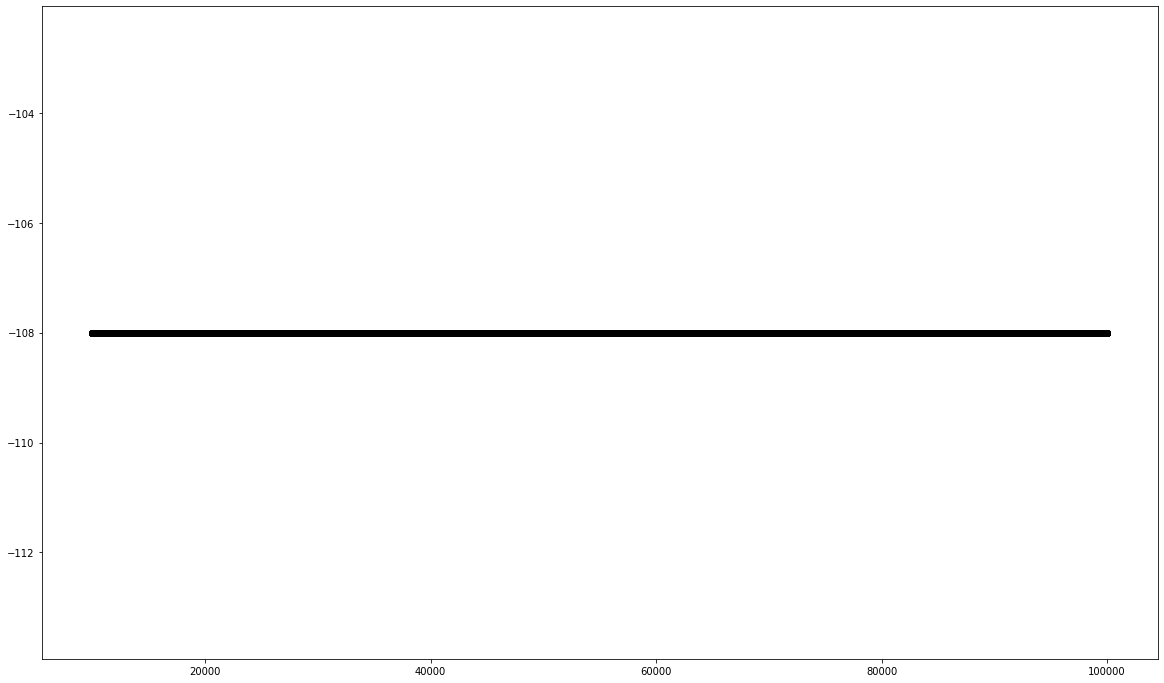

In [58]:
plt.figure(figsize = (20, 12))
plt.plot(en_mc, marker = "o", color = "black")

### Graph of Count of particle based on angle

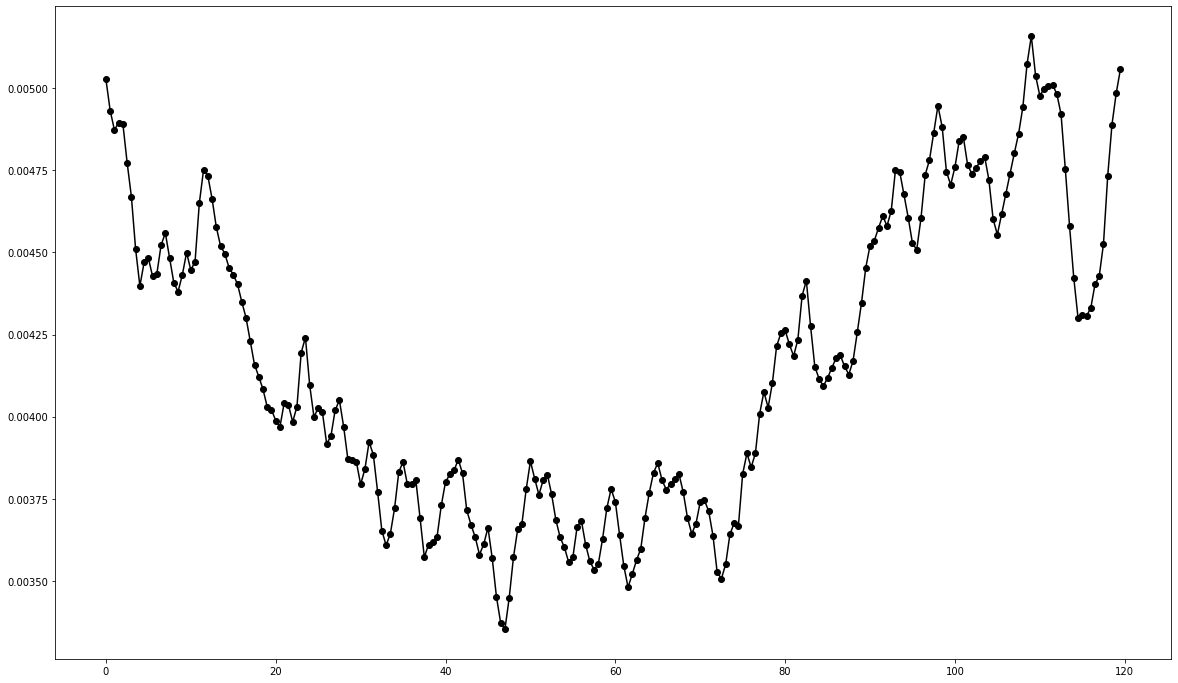

In [59]:
plt.figure(figsize = (20, 12))
plt.plot(avg, marker = "o", color = "black")

### Energy dependence on angle

In [60]:
df = np.array([])
index = np.array([])

for i in range(0, AngleInt):
    p = particle(i * phi, d1, Q2)

    #single potential
    if(type(ref) == potential):
        df = np.append(df, getEnergy(p, ref))
    
    #multiple potentials
    else:
        df = np.append(df, getEnergy_MUL(p, ref))
        
    index = np.append(index, i * phi)

#convert to pandas dataframe
df = pd.DataFrame(df, columns = ['Energy'])
df = df.set_index(index)

#save to csv
pd.DataFrame.to_csv(df, 'Results\\' + str(run) + '_Angle_Energy.csv')

### Graph of Energy dependence on angle

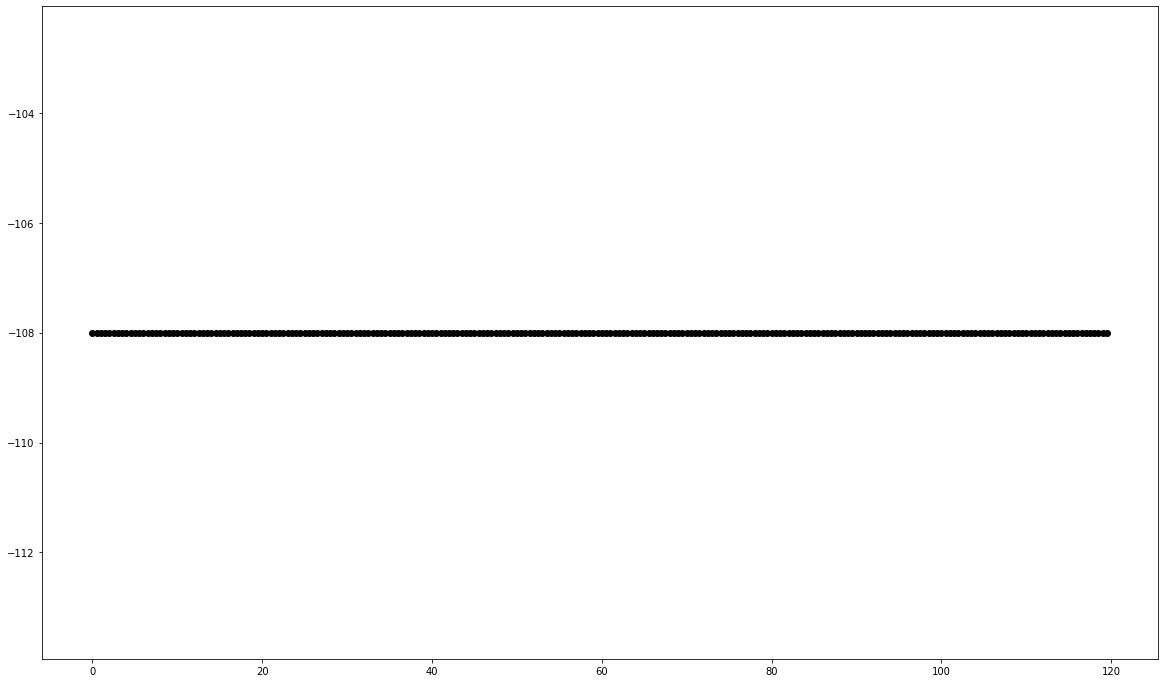

In [61]:
plt.figure(figsize = (20, 12))
plt.plot(df, marker = "o", color = "black")